Using device: cpu


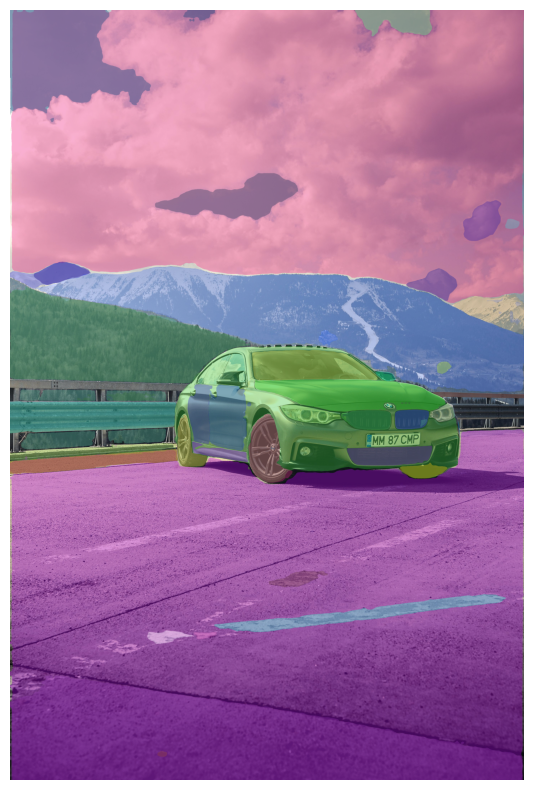

In [3]:
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator

# --- Helper function to visualize the masks ---
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)
    polygons = []
    color = []
    for ann in sorted_anns:
        m = ann['segmentation']
        img = np.ones((m.shape[0], m.shape[1], 3))
        color_mask = np.random.random((1, 3)).tolist()[0]
        for i in range(3):
            img[:,:,i] = color_mask[i]
        ax.imshow(np.dstack((img, m*0.35)))

# --- SETUP ---
# 1. Define paths to your model checkpoint and test image
model_checkpoint_path = "models/sam_vit_b_01ec64.pth" 
image_path = "data/test_images/car.jpg"

# 2. Set the device (use GPU if available)
device = "cpu"
print(f"Using device: {device}")

# 3. Load the image
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # Convert from BGR to RGB

# --- MODEL LOADING ---
# 4. Load the SAM model
model_type = "vit_b"
sam = sam_model_registry[model_type](checkpoint=model_checkpoint_path)
sam.to(device=device)

# --- MASK GENERATION ---
# 5. Create the Automatic Mask Generator and generate masks
# This will find all objects in the image automatically
# Use parameters that require less memory
mask_generator = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=16,  # This is the main change: check a 16x16 grid instead of 32x32
    pred_iou_thresh=0.86,
    stability_score_thresh=0.92,
    crop_n_layers=1,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=100,  # Ignores tiny specks
)
masks = mask_generator.generate(image)

# --- VISUALIZATION ---
# 6. Display the original image with the masks overlaid
plt.figure(figsize=(10,10))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show()

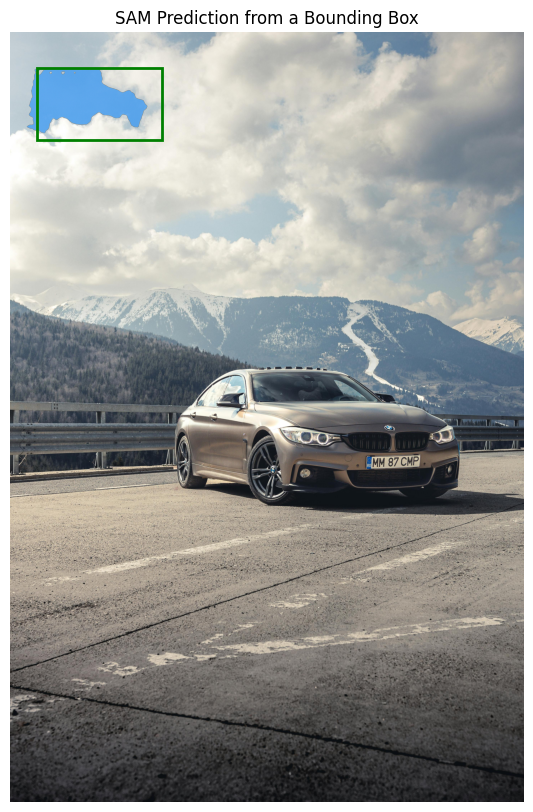

In [6]:
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
from segment_anything import sam_model_registry, SamPredictor

# --- Helper function to show a mask and a box ---
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - x0, box[3] - y0
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))    


model_checkpoint_path = "models/sam_vit_b_01ec64.pth" 
image_path = "data/test_images/car.jpg"
device = "cpu"
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# --- MODEL LOADING ---
# Note: We are now using SamPredictor
model_type = "vit_b"
sam = sam_model_registry[model_type](checkpoint=model_checkpoint_path)
sam.to(device=device)
predictor = SamPredictor(sam)

# --- PREDICTION ---
# 1. Process the image to prepare it for the model
predictor.set_image(image)

# 2. Define a bounding box for the object you want to segment
# FORMAT: [start_X, start_Y, end_X, end_Y]
# YOU WILL NEED TO GUESS AND ADJUST THESE COORDINATES for your image
input_box = np.array([150, 200, 850, 600]) # A bigger example box!

# 3. Run the prediction
masks, scores, logits = predictor.predict(
    box=input_box,
    multimask_output=False # We only want the single best mask
)

# --- VISUALIZATION ---
# 4. Display the results
plt.figure(figsize=(10, 10))
plt.imshow(image)
show_mask(masks[0], plt.gca())
show_box(input_box, plt.gca())
plt.title("SAM Prediction from a Bounding Box")
plt.axis('off')
plt.show()

Note: you may need to restart the kernel to use updated packages.
final text_encoder_type: bert-base-uncased


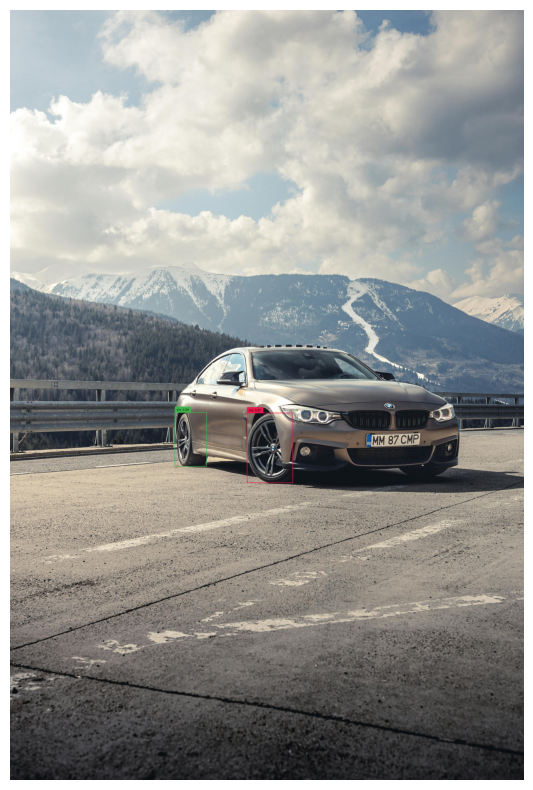

Detected Box Coordinates [X_start, Y_start, X_end, Y_end]:
[1322.9644 2250.8413 1577.7522 2640.6367]


In [10]:
# Install the required libraries for GroundingDINO
%pip install groundingdino-py supervision

# Import the necessary components
import torch
import cv2
import supervision as sv
from groundingdino.util.inference import Model

# --- SETUP ---
# Load the pre-trained GroundingDINO model
grounding_dino_model = Model(model_config_path="groundingdino/config/GroundingDINO_SwinT_OGC.py", model_checkpoint_path="weights/groundingdino_swint_ogc.pth")

# Define the image path and the text prompt
image_path = "data/test_images/car.jpg" # Make sure this is your image
text_prompt = "tire" # The object we want to find

# Load the image
image = cv2.imread(image_path)

# --- DETECTION ---
# Run the detection
detections, phrases = grounding_dino_model.predict_with_caption(
    image=image,
    caption=text_prompt,
    box_threshold=0.35,
    text_threshold=0.25
)

# --- VISUALIZATION ---
# Annotate the image with the results
box_annotator = sv.BoxAnnotator()
labels = [
    f"{phrase} {confidence:0.2f}"
    for phrase, confidence in zip(phrases, detections.confidence)
]
annotated_image = box_annotator.annotate(scene=image.copy(), detections=detections, labels=labels)

# Display the annotated image
sv.plot_image(annotated_image, (10, 10))

# Print the detected box coordinates
if len(detections.xyxy) > 0:
    first_box = detections.xyxy[0]
    print("Detected Box Coordinates [X_start, Y_start, X_end, Y_end]:")
    print(first_box)

final text_encoder_type: bert-base-uncased
--- Starting Segmentation ---
1. Parsed Prompt: Noun='railing', Modifier='None'
2. Found 1 instance(s) of 'railing'
3. Selected the only box found.
--> Final Selected Box: [   4.1257324 2054.083     2862.484     2483.7212   ]
4. Starting mask generation with SAM...
...SAM prediction complete.
5. Mask chosen. Returning final mask and box.


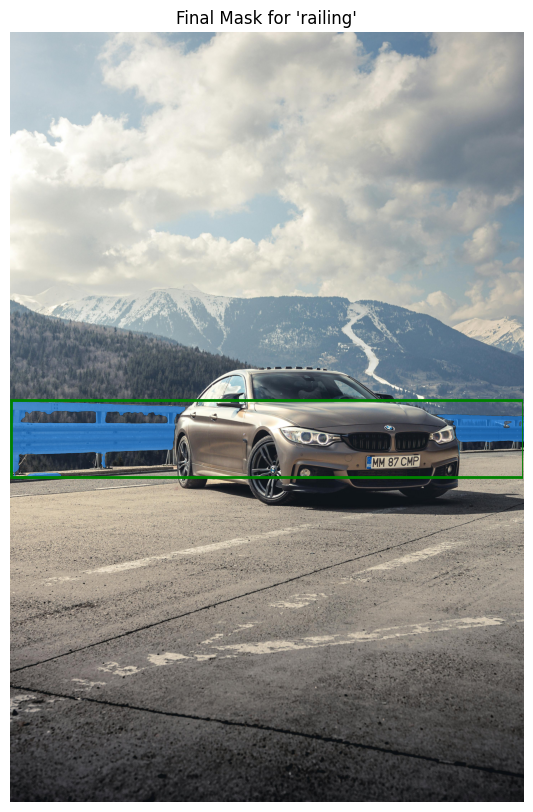

In [10]:
# Import the new class and other necessary libraries
from src.segment_utils import ObjectSegmenter
import cv2
import matplotlib.pyplot as plt
import supervision as sv
import numpy as np

# --- (Helper functions are the same as before) ---
def show_mask(mask, ax):
    color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - x0, box[3] - y0
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))

# --- SETUP ---
# Create an instance of our powerful segmenter
# This will load the models, which might take a moment the first time.
segmenter = ObjectSegmenter(device="cuda")

# Load the image
image_path = "data/test_images/car.jpg"
image = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# --- DEFINE PROMPT and RUN ---
# Try any prompt you want here!
prompt = "railing"
mask, box = segmenter.segment(image, prompt)

# --- VISUALIZE ---
if mask is not None:
    plt.figure(figsize=(10, 10))
    plt.imshow(image_rgb)
    show_mask(mask, plt.gca())
    show_box(box, plt.gca())
    plt.title(f"Final Mask for '{prompt}'")
    plt.axis('off')
    plt.show()
else:
    print(f"Could not find a mask for the prompt: '{prompt}'")

final text_encoder_type: bert-base-uncased
FastEditor initialized.
--- Starting Segmentation ---
1. Parsed Prompt: Noun='elephant', Modifier='None'
2. Found 1 instance(s) of 'elephant'
3. Selected the only box found.
--> Final Selected Box: [1439.1948  386.1635 2542.1396 2146.1414]
4. Starting mask generation with SAM...
...SAM prediction complete.
5. Mask chosen. Returning final mask and box.


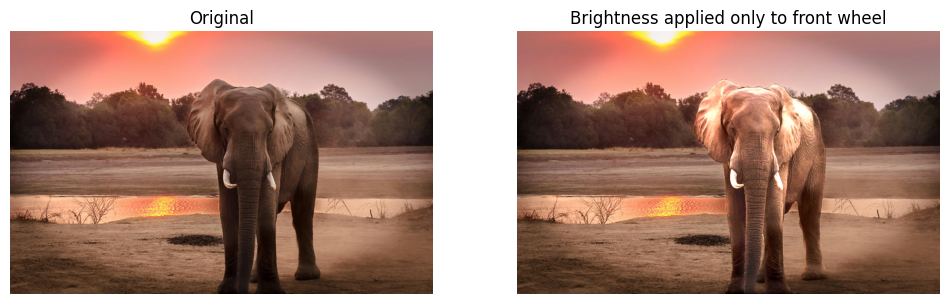

In [ ]:
# Test cell for mask-aware editing

import cv2
from src.segment_utils import ObjectSegmenter
from src.edit_utils import FastEditor
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# --- SETUP ---
segmenter = ObjectSegmenter(device="cuda")
editor = FastEditor()
image_path = "data/test_images/Car.jpg"
image_pil = Image.open(image_path).convert("RGB")
# Convert PIL image to CV2 format for the segmenter
image_cv2 = cv2.cvtColor(np.array(image_pil), cv2.COLOR_RGB2BGR)

# --- ACTION ---
# 1. Get the mask for the car
mask, box = segmenter.segment(image_cv2, "elephant")

# 2. Use the new mask-aware editor to make only the car super saturated
if mask is not None:
    saturated_car_image = editor.adjust_brightness(image_pil, factor=2.0, mask=mask)

    # --- VISUALIZE ---
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    ax[0].imshow(image_pil)
    ax[0].set_title("Original")
    ax[0].axis('off')

    ax[1].imshow(saturated_car_image)
    ax[1].set_title("Brightness applied only to Elephant")
    ax[1].axis('off')
    plt.show()
else:
    print("Could not find the car to apply the edit.")